In [3]:
#pip install pyforest

The 2012 US Army Anthropometric Survey (ANSUR II) was executed by the Natick Soldier Research, Development and Engineering Center (NSRDEC) from October 2010 to April 2012 and is comprised of personnel representing the total US Army force to include the US Army Active Duty, Reserves, and National Guard. In addition to the anthropometric and demographic data described below, the ANSUR II database also consists of 3D whole body, foot, and head scans of Soldier participants. These 3D data are not publicly available out of respect for the privacy of ANSUR II participants. The data from this survey are used for a wide range of equipment design, sizing, and tariffing applications within the military and has many potential commercial, industrial, and academic applications.

The ANSUR II working databases contain 93 anthropometric measurements which were directly measured, and 15 demographic/administrative variables explained below. The ANSUR II Male working database contains a total sample of 4,082 subjects. The ANSUR II Female working database contains a total sample of 1,986 subjects.


data dict:
https://data.world/datamil/ansur-ii-data-dictionary/workspace/file?filename=ANSUR+II+Databases+Overview.pdf


# Import libraries

In [4]:
import pyforest

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.metrics import make_scorer
from sklearn.metrics import classification_report,confusion_matrix,plot_confusion_matrix
from sklearn.metrics import roc_curve, auc

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")

plt.style.use('classic')
sns.set_style("white")

In [5]:
def plot_multiclass_roc(clf, X_test, y_test, n_classes, figsize=(5,5)):
    y_score = clf.decision_function(X_test)

    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %i' % (roc_auc[i], i))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

In [6]:
def plot_multiclass_roc_for_tree(clf, X_test, y_test, n_classes, figsize=(5,5)):
    y_score = clf.predict_proba(X_test)

    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %i' % (roc_auc[i], i))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

# Ingest Data from links below and make a dataframe
- Soldiers Male : https://query.data.world/s/h3pbhckz5ck4rc7qmt2wlknlnn7esr
- Soldiers Female : https://query.data.world/s/sq27zz4hawg32yfxksqwijxmpwmynq

In [7]:
#df_male = pd.read_csv('https://query.data.world/s/h3pbhckz5ck4rc7qmt2wlknlnn7esr',encoding='latin-1')
df_male = pd.read_csv('ANSUR_II_MALE_Public.csv',encoding='latin-1')

<IPython.core.display.Javascript object>

In [8]:
#df_female= pd.read_csv('https://query.data.world/s/sq27zz4hawg32yfxksqwijxmpwmynq')
df_female= pd.read_csv('ANSUR_II_FEMALE_Public.csv')

<IPython.core.display.Javascript object>

# EDA
- Drop unnecessary colums
- Drop DODRace class if value count below 500 (we assume that our data model can't learn if it is below 500)
- Find unusual value in Weightlbs

In [9]:
df_male.head()

,subjectid,abdominalextensiondepthsitting,acromialheight,acromionradialelength,anklecircumference,axillaheight,balloffootcircumference,balloffootlength,biacromialbreadth,bicepscircumferenceflexed,...,Branch,PrimaryMOS,SubjectsBirthLocation,SubjectNumericRace,Ethnicity,DODRace,Age,Heightin,Weightlbs,WritingPreference
0,10027,266,1467,337,222,1347,253,202,401,369,...,Combat Arms,19D,North Dakota,1,NaN,1,41,71,180,Right hand
1,10032,233,1395,326,220,1293,245,193,394,338,...,Combat Support,68W,New York,1,NaN,1,35,68,160,Left hand
2,10033,287,1430,341,230,1327,256,196,427,408,...,Combat Support,68W,New York,2,NaN,2,42,68,205,Left hand
3,10092,234,1347,310,230,1239,262,199,401,359,...,Combat Service Support,88M,Wisconsin,1,NaN,1,31,66,175,Right hand
4,10093,250,1585,372,247,1478,267,224,435,356,...,Combat Service Support,92G,North Carolina,2,NaN,2,21,77,213,Right hand


In [10]:
df_female.head()

,SubjectId,abdominalextensiondepthsitting,acromialheight,acromionradialelength,anklecircumference,axillaheight,balloffootcircumference,balloffootlength,biacromialbreadth,bicepscircumferenceflexed,...,Branch,PrimaryMOS,SubjectsBirthLocation,SubjectNumericRace,Ethnicity,DODRace,Age,Heightin,Weightlbs,WritingPreference
0,10037,231,1282,301,204,1180,222,177,373,315,...,Combat Support,92Y,Germany,2,NaN,2,26,61,142,Right hand
1,10038,194,1379,320,207,1292,225,178,372,272,...,Combat Service Support,25U,California,3,Mexican,3,21,64,120,Right hand
2,10042,183,1369,329,233,1271,237,196,397,300,...,Combat Service Support,35D,Texas,1,NaN,1,23,68,147,Right hand
3,10043,261,1356,306,214,1250,240,188,384,364,...,Combat Service Support,25U,District of Columbia,8,Caribbean Islander,2,22,66,175,Right hand
4,10051,309,1303,308,214,1210,217,182,378,320,...,Combat Arms,42A,Texas,1,NaN,1,45,63,195,Right hand


In [11]:
print(df_male.shape)
print(df_female.shape)

(4082, 108)
(1986, 108)


In [12]:
data = pd.concat([df_male,df_female], axis=0,ignore_index=True)

<IPython.core.display.Javascript object>

In [13]:
data.shape

(6068, 109)

In [14]:
data

,subjectid,abdominalextensiondepthsitting,acromialheight,acromionradialelength,anklecircumference,axillaheight,balloffootcircumference,balloffootlength,biacromialbreadth,bicepscircumferenceflexed,...,PrimaryMOS,SubjectsBirthLocation,SubjectNumericRace,Ethnicity,DODRace,Age,Heightin,Weightlbs,WritingPreference,SubjectId
0,10027.0,266,1467,337,222,1347,253,202,401,369,...,19D,North Dakota,1,NaN,1,41,71,180,Right hand,NaN
1,10032.0,233,1395,326,220,1293,245,193,394,338,...,68W,New York,1,NaN,1,35,68,160,Left hand,NaN
2,10033.0,287,1430,341,230,1327,256,196,427,408,...,68W,New York,2,NaN,2,42,68,205,Left hand,NaN
3,10092.0,234,1347,310,230,1239,262,199,401,359,...,88M,Wisconsin,1,NaN,1,31,66,175,Right hand,NaN
4,10093.0,250,1585,372,247,1478,267,224,435,356,...,92G,North Carolina,2,NaN,2,21,77,213,Right hand,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6063,NaN,285,1392,335,223,1297,252,196,368,299,...,42A,Texas,3,Mexican,3,51,67,180,Right hand,29501.0
6064,NaN,262,1324,301,202,1204,236,181,378,294,...,25U,Texas,3,Mexican,3,40,63,150,Right hand,29502.0
6065,NaN,260,1334,318,213,1259,234,183,363,332,...,42A,Texas,2,NaN,2,40,66,168,Right hand,29503.0
6066,NaN,205,1293,302,199,1207,213,163,376,276,...,92Y,Texas,3,Mexican,3,31,63,133,Right hand,29511.0


In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6068 entries, 0 to 6067
Columns: 109 entries, subjectid to SubjectId
dtypes: float64(2), int64(98), object(9)
memory usage: 5.0+ MB


In [16]:
data.isnull().sum().any()

True

In [17]:
data.duplicated().sum()

0

1    3792
2    1298
3     679
4     188
6      59
5      49
8       3
Name: DODRace, dtype: int64


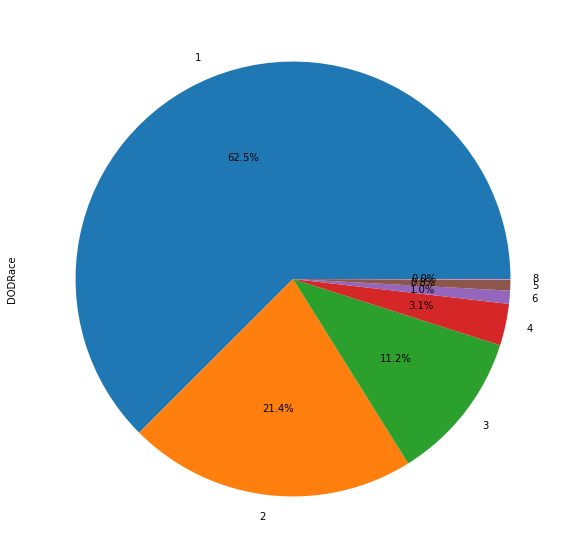

In [18]:
print(data["DODRace"].value_counts())
data["DODRace"].value_counts().plot(kind="pie", autopct='%1.1f%%',figsize=(10,10));

In [19]:
drop_list =[]
for col in data.columns:
  if data[col].isnull().sum()>1800:
    print(f"{col} = {data[col].isnull().sum()}")
    drop_list.append(col)
  
  
drop_list 

subjectid = 1986
Ethnicity = 4647
SubjectId = 4082


['subjectid', 'Ethnicity', 'SubjectId']

In [20]:
data.drop(drop_list,axis=1, inplace=True)

In [21]:
data.isnull().sum().any()

False

In [22]:
data.shape

(6068, 106)

In [23]:
# to find how many unique values object features have
for col in data.select_dtypes(exclude=[np.number]).columns:
  print(f"{col} has {data[col].nunique()} unique values")

<IPython.core.display.Javascript object>

Gender has 2 unique value
Date has 253 unique value
Installation has 12 unique value
Component has 3 unique value
Branch has 3 unique value
PrimaryMOS has 285 unique value
SubjectsBirthLocation has 152 unique value
WritingPreference has 3 unique value


In [24]:
data.groupby(["Component"])["DODRace"].value_counts()

Component            DODRace
Army National Guard  1          1855
                     2           499
                     3           253
                     4            60
                     5            24
                     6            17
Army Reserve         1           114
                     2            52
                     3            41
                     4             9
                     6             3
                     5             1
Regular Army         1          1823
                     2           747
                     3           385
                     4           119
                     6            39
                     5            24
                     8             3
Name: DODRace, dtype: int64

In [25]:
data.groupby(["Component","Branch"])["DODRace"].value_counts()

Component            Branch                  DODRace
Army National Guard  Combat Arms             1          623
                                             2           79
                                             3           74
                                             4           18
                                             5            9
                                             6            4
                     Combat Service Support  1          917
                                             2          312
                                             3          142
                                             4           33
                                             6           11
                                             5           10
                     Combat Support          1          315
                                             2          108
                                             3           37
                                             4 

In [26]:
drop_list1 = ["Date", "Installation", "Component","PrimaryMOS"]

data.drop(drop_list1,axis=1,inplace=True)

In [27]:
data.columns

Index(['abdominalextensiondepthsitting', 'acromialheight',
       'acromionradialelength', 'anklecircumference', 'axillaheight',
       'balloffootcircumference', 'balloffootlength', 'biacromialbreadth',
       'bicepscircumferenceflexed', 'bicristalbreadth',
       ...
       'wristheight', 'Gender', 'Branch', 'SubjectsBirthLocation',
       'SubjectNumericRace', 'DODRace', 'Age', 'Heightin', 'Weightlbs',
       'WritingPreference'],
      dtype='object', length=102)

In [28]:
data.SubjectNumericRace.value_counts()

1        3561
2        1026
3         541
31        160
51        126
8         116
4         109
21         60
6          59
41         46
61         35
23         34
28         26
251        20
5          18
18         18
25         14
351        10
38          9
64          8
62          8
35          8
42          7
63          7
231         6
43          5
235         4
218         3
651         2
2351        2
318         2
641         2
451         2
423         2
431         2
2518        2
48          1
631         1
4251        1
428         1
238         1
358         1
425         1
42351       1
Name: SubjectNumericRace, dtype: int64

In [29]:
data.drop("SubjectNumericRace",axis=1,inplace=True)

In [30]:
data.DODRace.unique()

array([1, 2, 3, 4, 5, 6, 8], dtype=int64)

In [31]:
data["DODRace"] = data.DODRace.map({1 : "White", 2 : "Black", 3 : "Hispanic", 4 : "Asian", 5 : "Native American", 6 : "Pacific Islander", 8 : "Other"})

In [32]:
data.DODRace.value_counts()

White               3792
Black               1298
Hispanic             679
Asian                188
Pacific Islander      59
Native American       49
Other                  3
Name: DODRace, dtype: int64

In [33]:
data = data[(data["DODRace"] == "White") | (data["DODRace"] == "Black") | (data["DODRace"] == "Hispanic")]
data

,abdominalextensiondepthsitting,acromialheight,acromionradialelength,anklecircumference,axillaheight,balloffootcircumference,balloffootlength,biacromialbreadth,bicepscircumferenceflexed,bicristalbreadth,...,wristcircumference,wristheight,Gender,Branch,SubjectsBirthLocation,DODRace,Age,Heightin,Weightlbs,WritingPreference
0,266,1467,337,222,1347,253,202,401,369,274,...,175,853,Male,Combat Arms,North Dakota,White,41,71,180,Right hand
1,233,1395,326,220,1293,245,193,394,338,257,...,167,815,Male,Combat Support,New York,White,35,68,160,Left hand
2,287,1430,341,230,1327,256,196,427,408,261,...,180,831,Male,Combat Support,New York,Black,42,68,205,Left hand
3,234,1347,310,230,1239,262,199,401,359,262,...,176,793,Male,Combat Service Support,Wisconsin,White,31,66,175,Right hand
4,250,1585,372,247,1478,267,224,435,356,263,...,188,954,Male,Combat Service Support,North Carolina,Black,21,77,213,Right hand
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6063,285,1392,335,223,1297,252,196,368,299,312,...,162,836,Female,Combat Support,Texas,Hispanic,51,67,180,Right hand
6064,262,1324,301,202,1204,236,181,378,294,287,...,157,804,Female,Combat Support,Texas,Hispanic,40,63,150,Right hand
6065,260,1334,318,213,1259,234,183,363,332,299,...,159,774,Female,Combat Support,Texas,Black,40,66,168,Right hand
6066,205,1293,302,199,1207,213,163,376,276,280,...,146,769,Female,Combat Support,Texas,Hispanic,31,63,133,Right hand


In [34]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5769 entries, 0 to 6067
Columns: 101 entries, abdominalextensiondepthsitting to WritingPreference
dtypes: int64(96), object(5)
memory usage: 4.5+ MB


In [35]:
data.reset_index(drop=True, inplace=True)

In [36]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
abdominalextensiondepthsitting,5769.0,247.254290,37.457748,155.0,220.0,243.0,272.0,451.0
acromialheight,5769.0,1408.630265,78.303123,1146.0,1353.0,1412.0,1464.0,1683.0
acromionradialelength,5769.0,328.071590,20.444554,249.0,314.0,328.0,342.0,393.0
anklecircumference,5769.0,225.201768,15.965783,156.0,214.0,225.0,235.0,293.0
axillaheight,5769.0,1301.902583,71.260913,1062.0,1252.0,1304.0,1351.0,1553.0
...,...,...,...,...,...,...,...,...
wristcircumference,5769.0,169.308372,13.060900,124.0,159.0,171.0,179.0,216.0
wristheight,5769.0,831.334547,47.321580,688.0,798.0,831.0,864.0,1009.0
Age,5769.0,29.776391,8.706610,17.0,23.0,28.0,36.0,58.0
Heightin,5769.0,68.359508,3.836336,56.0,66.0,69.0,71.0,94.0


In [37]:
for col in data.select_dtypes(include=[np.number]).columns:
    if data[col].min() == 0:
        print(col)


<IPython.core.display.Javascript object>

Weightlbs


In [38]:
data["Weightlbs"].argmin()

824

In [39]:
data.drop(index = data["Weightlbs"].argmin(), inplace=True)

In [40]:
data.reset_index(drop=True, inplace=True)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<AxesSubplot:>

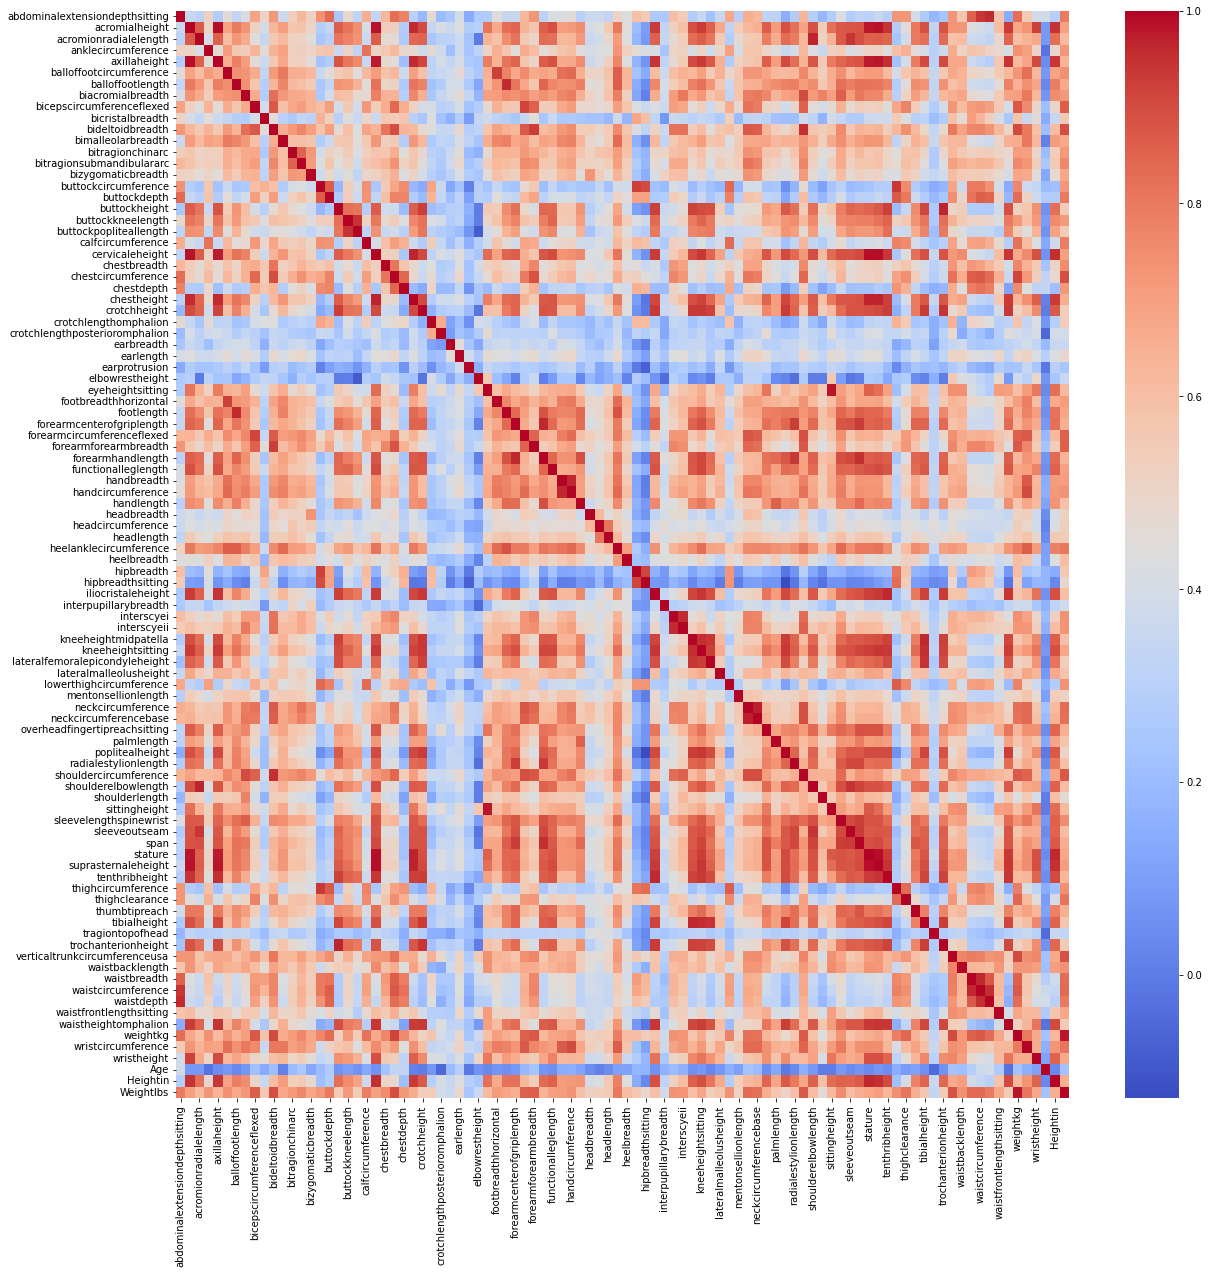

In [41]:
plt.figure(figsize=(20,20))
sns.heatmap(data.corr(), cmap ="coolwarm")

In [42]:
df_temp = data.corr()

count = "done"
feature =[]
collinear=[]
for col in df_temp.columns:
    for i in df_temp.index:
        if (df_temp[col][i]> .9 and df_temp[col][i] < 1) or (df_temp[col][i]< -.9 and df_temp[col][i] > -1) :
                feature.append(col)
                collinear.append(i)
                # print(f"multicolinearity alert in between {col} - {i}")
print("Number of strong corelated features:", count) 

Number of strong corelated features: done


In [43]:
df_col = pd.DataFrame([feature, collinear], index=["feature","collinear"]).T
df_col

<IPython.core.display.Javascript object>

,feature,collinear
0,abdominalextensiondepthsitting,waistcircumference
1,abdominalextensiondepthsitting,waistdepth
2,acromialheight,axillaheight
3,acromialheight,cervicaleheight
4,acromialheight,chestheight
...,...,...
297,Heightin,chestheight
298,Heightin,stature
299,Heightin,suprasternaleheight
300,Heightin,waistheightomphalion


In [44]:
df_col.value_counts("feature")

feature
kneeheightsitting        19
cervicaleheight          15
tenthribheight           15
waistheightomphalion     15
axillaheight             15
                         ..
handbreadth               1
neckcircumferencebase     1
neckcircumference         1
Weightlbs                 1
hipbreadthsitting         1
Length: 61, dtype: int64

# DATA Preprocessing

In [45]:
X= data.drop("DODRace",axis=1)
X = pd.get_dummies(data=X,drop_first=True)
y= data.DODRace

<IPython.core.display.Javascript object>

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=6, stratify =y)

<IPython.core.display.Javascript object>

In [47]:
scaler =MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Modelling

## 1. Logistic model

test scores 
--------------
[[239  11  10]
 [  6 104  25]
 [ 16  99 644]]
              precision    recall  f1-score   support

       Black       0.92      0.92      0.92       260
    Hispanic       0.49      0.77      0.60       135
       White       0.95      0.85      0.90       759

    accuracy                           0.86      1154
   macro avg       0.78      0.85      0.80      1154
weighted avg       0.89      0.86      0.87      1154



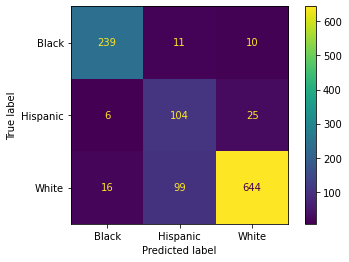

In [48]:
log_model = LogisticRegression(class_weight='balanced',max_iter=10000,random_state=6)

log_model.fit(X_train,y_train)

y_pred = log_model.predict(X_test)

print("test scores","\n--------------")

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test, y_pred))
plot_confusion_matrix(log_model,X_test,y_test,values_format='.0f')

train scores 
--------------
[[ 966   46   26]
 [  21  453   69]
 [  64  353 2616]]
              precision    recall  f1-score   support

       Black       0.92      0.93      0.92      1038
    Hispanic       0.53      0.83      0.65       543
       White       0.96      0.86      0.91      3033

    accuracy                           0.87      4614
   macro avg       0.81      0.88      0.83      4614
weighted avg       0.90      0.87      0.88      4614



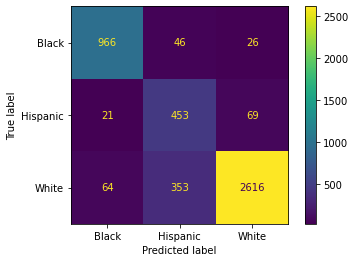

In [49]:
y_pred = log_model.predict(X_train)
print("train scores","\n--------------")
print(confusion_matrix(y_train,y_pred))
print(classification_report(y_train, y_pred))
plot_confusion_matrix(log_model,X_train,y_train);#x

In [50]:
f1score= make_scorer(f1_score, average="weighted")


In [51]:
model = LogisticRegression(class_weight='balanced',max_iter=10000,random_state=6)
scores = cross_val_score(model, X_train, y_train, cv = 5, scoring = f1score, n_jobs = -1)
print([round(i, 4) for i in scores], "\n")
print(f" f1score : %{scores.mean()*100:.2f}, std : %{scores.std()*100:.3f} \n")

[0.8656, 0.8698, 0.8635, 0.874, 0.8708] 

 f1score : %86.87, std : %0.374 



In [52]:
f1_Hispanic =  make_scorer(f1_score, average=None, labels=["Hispanic"] )

In [53]:
param_grid = { "class_weight" : ["balanced", None],
              'penalty': ["l1","l2"],
              'solver' : ['saga','lbfgs'],
              }

In [54]:
model = LogisticRegression(class_weight='balanced',max_iter=10000,random_state=6)
log_model_grid = GridSearchCV(model, param_grid, verbose=3, scoring=f1_Hispanic, refit=True,n_jobs=-1)

In [55]:
log_model_grid.fit(X_train,y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=10000, random_state=6),
             n_jobs=-1,
             param_grid={'class_weight': ['balanced', None],
                         'penalty': ['l1', 'l2'], 'solver': ['saga', 'lbfgs']},
             scoring=make_scorer(f1_score, average=None, labels=['Hispanic']),
             verbose=3)

In [56]:
log_model_grid.best_params_

{'class_weight': None, 'penalty': 'l2', 'solver': 'saga'}

[[234   3  23]
 [  8  73  54]
 [  7  15 737]]
              precision    recall  f1-score   support

       Black       0.94      0.90      0.92       260
    Hispanic       0.80      0.54      0.65       135
       White       0.91      0.97      0.94       759

    accuracy                           0.90      1154
   macro avg       0.88      0.80      0.83      1154
weighted avg       0.90      0.90      0.90      1154



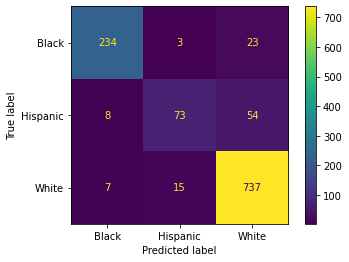

In [57]:
y_pred = log_model_grid.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
plot_confusion_matrix(log_model_grid,X_test,y_test);

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

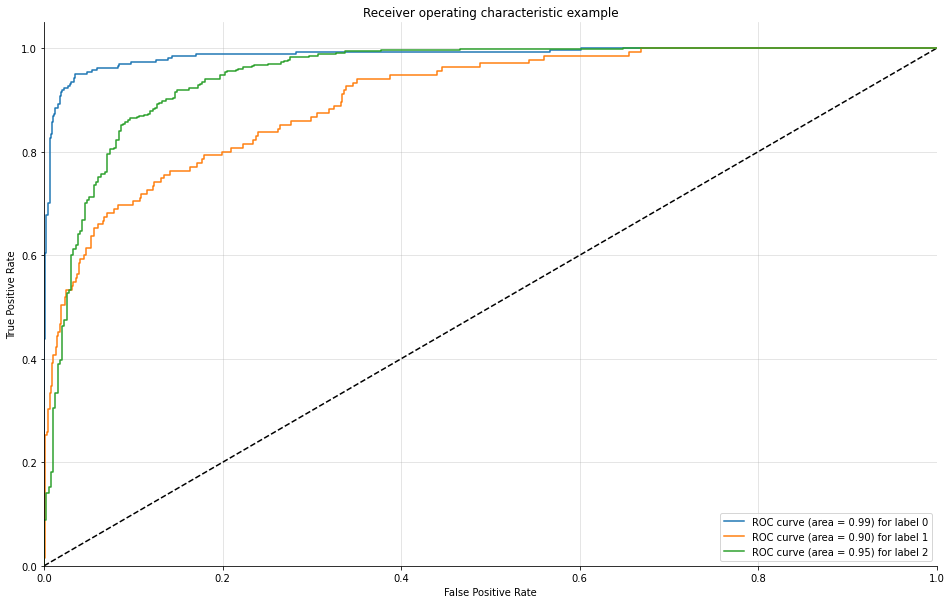

In [58]:
plot_multiclass_roc(log_model_grid, X_test, y_test, n_classes=3, figsize=(16, 10))

## 2. SVC

test scores 
--------------
[[239   9  12]
 [  8 102  25]
 [ 14 118 627]]
              precision    recall  f1-score   support

       Black       0.92      0.92      0.92       260
    Hispanic       0.45      0.76      0.56       135
       White       0.94      0.83      0.88       759

    accuracy                           0.84      1154
   macro avg       0.77      0.83      0.79      1154
weighted avg       0.88      0.84      0.85      1154



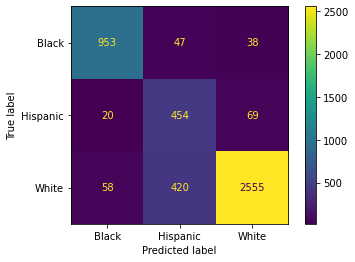

In [59]:
svm_model = SVC(class_weight="balanced")

svm_model.fit(X_train, y_train)

y_pred = svm_model.predict(X_test)

print("test scores","\n--------------")

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
plot_confusion_matrix(svm_model,X_train,y_train);#x

train scores 
--------------
[[ 953   47   38]
 [  20  454   69]
 [  58  420 2555]]
              precision    recall  f1-score   support

       Black       0.92      0.92      0.92      1038
    Hispanic       0.49      0.84      0.62       543
       White       0.96      0.84      0.90      3033

    accuracy                           0.86      4614
   macro avg       0.79      0.87      0.81      4614
weighted avg       0.90      0.86      0.87      4614



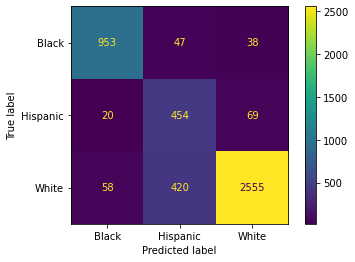

In [60]:
y_pred = svm_model.predict(X_train)

print("train scores","\n--------------")

print(confusion_matrix(y_train,y_pred))
print(classification_report(y_train, y_pred))
plot_confusion_matrix(svm_model,X_train,y_train);

model = SVC('class_weight="balanced"')
scores = cross_val_score(model, X_train, y_train, cv = 5, scoring = f1_Hispanic, n_jobs = -1)
print([round(i, 4) for i in scores], "\n")
print(f" {i:20} : %{scores.mean()*100:.2f}, std : %{scores.std()*100:.3f} \n")

In [61]:
param_grid = {'C': np.linspace(200,400,5),
              'decision_function_shape' : ['ovr','ovo'],
              'gamma': ["scale", "auto", 1,0.1,0.01],
              'kernel': ['rbf'],
              'class_weight':["balanced",None]}

<IPython.core.display.Javascript object>

In [62]:
model = SVC(class_weight="balanced")
svm_model_grid = GridSearchCV(model, param_grid, verbose=3, scoring=f1_Hispanic, refit=True,n_jobs=-1)

In [63]:
svm_model_grid.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


GridSearchCV(estimator=SVC(class_weight='balanced'), n_jobs=-1,
             param_grid={'C': array([200., 250., 300., 350., 400.]),
                         'class_weight': ['balanced', None],
                         'decision_function_shape': ['ovr', 'ovo'],
                         'gamma': ['scale', 'auto', 1, 0.1, 0.01],
                         'kernel': ['rbf']},
             scoring=make_scorer(f1_score, average=None, labels=['Hispanic']),
             verbose=3)

In [64]:
svm_model_grid.best_params_

{'C': 400.0,
 'class_weight': None,
 'decision_function_shape': 'ovr',
 'gamma': 'auto',
 'kernel': 'rbf'}

[[239   2  19]
 [  6  78  51]
 [  8  18 733]]
              precision    recall  f1-score   support

       Black       0.94      0.92      0.93       260
    Hispanic       0.80      0.58      0.67       135
       White       0.91      0.97      0.94       759

    accuracy                           0.91      1154
   macro avg       0.88      0.82      0.85      1154
weighted avg       0.91      0.91      0.91      1154



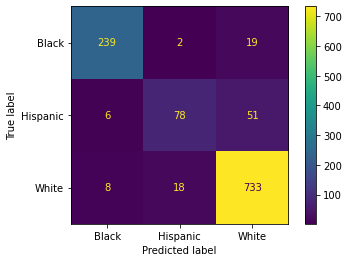

In [65]:
y_pred = svm_model_grid.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
plot_confusion_matrix(svm_model_grid,X_test,y_test);

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

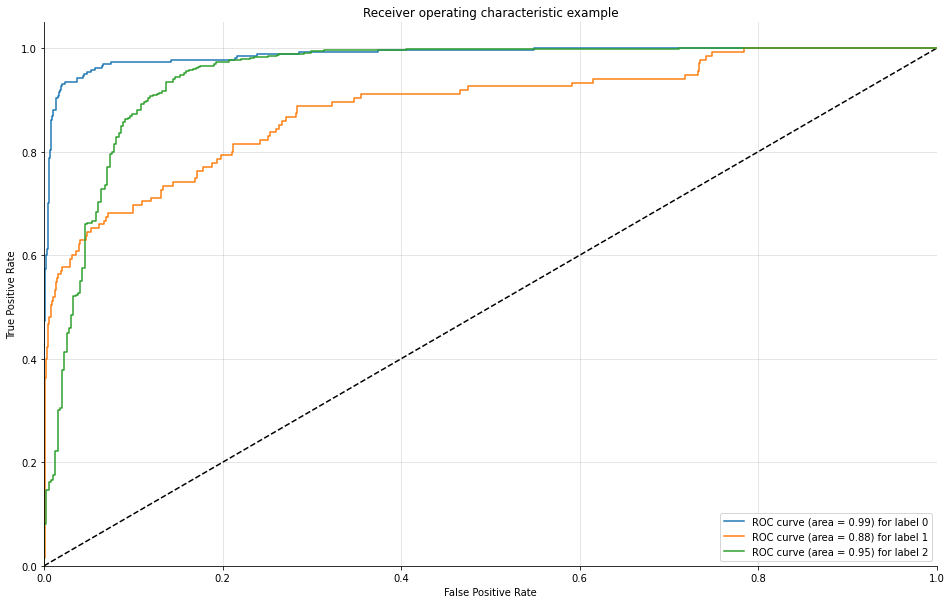

In [66]:
plot_multiclass_roc(svm_model_grid, X_test, y_test, n_classes=3, figsize=(16, 10))

## 3. RF

In [67]:
rf_mod = RandomForestClassifier()

In [68]:
rf_mod.fit(X_train,y_train)

RandomForestClassifier()

[[191   2  67]
 [  9  14 112]
 [ 10   2 747]]
              precision    recall  f1-score   support

       Black       0.91      0.73      0.81       260
    Hispanic       0.78      0.10      0.18       135
       White       0.81      0.98      0.89       759

    accuracy                           0.82      1154
   macro avg       0.83      0.61      0.63      1154
weighted avg       0.83      0.82      0.79      1154



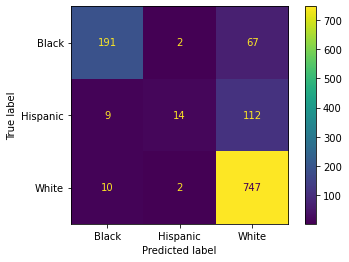

In [69]:
y_pred = rf_mod.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
plot_confusion_matrix(rf_mod,X_test,y_test);#x

[[1038    0    0]
 [   0  543    0]
 [   0    0 3033]]
              precision    recall  f1-score   support

       Black       1.00      1.00      1.00      1038
    Hispanic       1.00      1.00      1.00       543
       White       1.00      1.00      1.00      3033

    accuracy                           1.00      4614
   macro avg       1.00      1.00      1.00      4614
weighted avg       1.00      1.00      1.00      4614



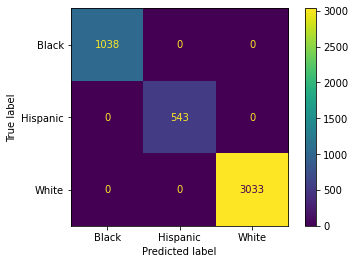

In [70]:
y_pred = rf_mod.predict(X_train)
print(confusion_matrix(y_train, y_pred))
print(classification_report(y_train, y_pred))
plot_confusion_matrix(rf_mod,X_train,y_train);

In [71]:
param_grid = {'n_estimators':[400,500],
             'criterion': ["gini","entropy"],
             'max_depth':[10,12,14,16],
             'min_samples_split':[18,20,22],
             'class_weight': ['balanced',None]}

In [72]:
rf_model = RandomForestClassifier()
rf_grid_model = GridSearchCV(rf_model, param_grid, verbose=3, scoring=f1_Hispanic, refit=True,n_jobs=-1)

In [73]:
rf_grid_model.fit(X_train,y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'class_weight': ['balanced', None],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [10, 12, 14, 16],
                         'min_samples_split': [18, 20, 22],
                         'n_estimators': [400, 500]},
             scoring=make_scorer(f1_score, average=None, labels=['Hispanic']),
             verbose=3)

In [74]:
rf_grid_model.best_params_

{'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 10,
 'min_samples_split': 22,
 'n_estimators': 400}

[[ 988    9   41]
 [   8  482   53]
 [  66  127 2840]]
              precision    recall  f1-score   support

       Black       0.93      0.95      0.94      1038
    Hispanic       0.78      0.89      0.83       543
       White       0.97      0.94      0.95      3033

    accuracy                           0.93      4614
   macro avg       0.89      0.93      0.91      4614
weighted avg       0.94      0.93      0.94      4614



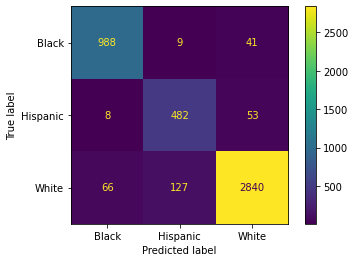

In [75]:
y_pred = rf_grid_model.predict(X_train)
print(confusion_matrix(y_train, y_pred))
print(classification_report(y_train, y_pred))
plot_confusion_matrix(rf_grid_model,X_train,y_train);

[[214   5  41]
 [ 15  56  64]
 [ 31  65 663]]
              precision    recall  f1-score   support

       Black       0.82      0.82      0.82       260
    Hispanic       0.44      0.41      0.43       135
       White       0.86      0.87      0.87       759

    accuracy                           0.81      1154
   macro avg       0.71      0.70      0.71      1154
weighted avg       0.81      0.81      0.81      1154



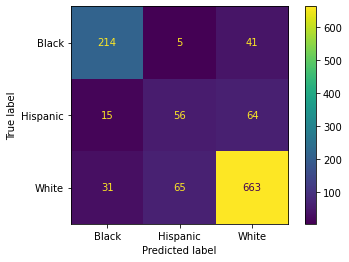

In [76]:
y_pred = rf_grid_model.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
plot_confusion_matrix(rf_grid_model,X_test,y_test);

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

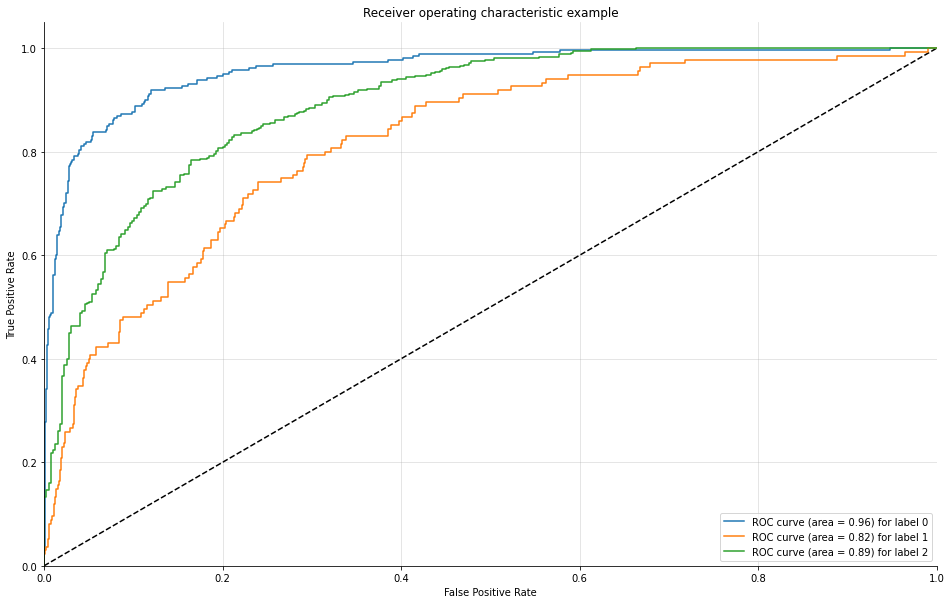

In [77]:
plot_multiclass_roc_for_tree(rf_grid_model, X_test, y_test, n_classes=3, figsize=(16, 10))

## 4. XGBoost

In [78]:
xgb_model = XGBClassifier()

In [79]:
xgb_model.fit(X_train,y_train)


[20:47:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

[[219   0  41]
 [  9  60  66]
 [ 14  11 734]]
              precision    recall  f1-score   support

       Black       0.90      0.84      0.87       260
    Hispanic       0.85      0.44      0.58       135
       White       0.87      0.97      0.92       759

    accuracy                           0.88      1154
   macro avg       0.87      0.75      0.79      1154
weighted avg       0.88      0.88      0.87      1154



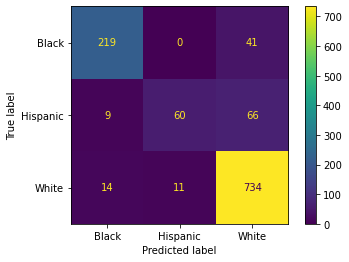

In [80]:
y_pred = xgb_model.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
plot_confusion_matrix(xgb_model,X_test,y_test);#x

[[1038    0    0]
 [   0  543    0]
 [   0    0 3033]]
              precision    recall  f1-score   support

       Black       1.00      1.00      1.00      1038
    Hispanic       1.00      1.00      1.00       543
       White       1.00      1.00      1.00      3033

    accuracy                           1.00      4614
   macro avg       1.00      1.00      1.00      4614
weighted avg       1.00      1.00      1.00      4614



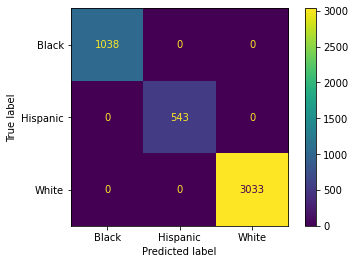

In [81]:
y_pred = xgb_model.predict(X_train)
print(confusion_matrix(y_train, y_pred))
print(classification_report(y_train, y_pred))
plot_confusion_matrix(xgb_model,X_train,y_train);

In [82]:
from sklearn.utils import class_weight
classes_weights = class_weight.compute_sample_weight(class_weight='balanced', y=y_train)
classes_weights

array([0.50708869, 0.50708869, 0.50708869, ..., 0.50708869, 0.50708869,
       2.83241252])

In [83]:
comp = pd.DataFrame(classes_weights)

comp["label"]= y_train.reset_index(drop=True)
comp.groupby("label")[0].value_counts()

<IPython.core.display.Javascript object>

label     0       
Black     1.481696    1038
Hispanic  2.832413     543
White     0.507089    3033
Name: 0, dtype: int64

In [84]:
param_grid = {"n_estimators":[100, 300],
              'max_depth':[3,5,6],
              "learning_rate": [0.1, 0.3],
              "subsample":[0.5, 1],
              "colsample_bytree":[0.5, 1]}

In [85]:
xgb_model = XGBClassifier()
xgb_grid_model = GridSearchCV(xgb_model, param_grid, scoring=f1_Hispanic, n_jobs = -1,refit=True, verbose = 2).fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[21:18:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [86]:
xgb_grid_model.best_params_

{'colsample_bytree': 0.5,
 'learning_rate': 0.3,
 'max_depth': 3,
 'n_estimators': 100,
 'subsample': 1}

[[222   0  38]
 [  9  63  63]
 [ 11  16 732]]
              precision    recall  f1-score   support

       Black       0.92      0.85      0.88       260
    Hispanic       0.80      0.47      0.59       135
       White       0.88      0.96      0.92       759

    accuracy                           0.88      1154
   macro avg       0.86      0.76      0.80      1154
weighted avg       0.88      0.88      0.87      1154



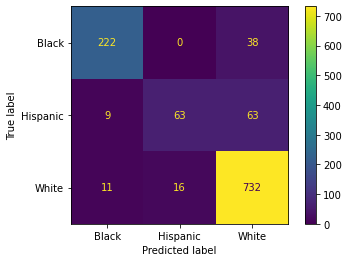

In [87]:
y_pred = xgb_grid_model.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
plot_confusion_matrix(xgb_grid_model,X_test,y_test);

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

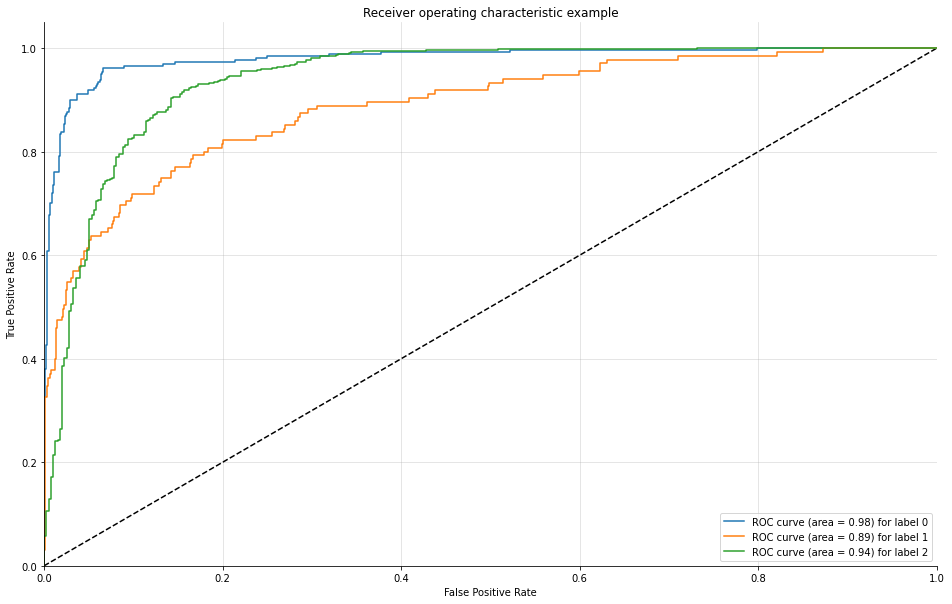

In [88]:
plot_multiclass_roc_for_tree(xgb_grid_model, X_test, y_test, n_classes=3, figsize=(16, 10))

---
---

## Prediction

In [89]:
X.describe().loc["mean"]

abdominalextensiondepthsitting      247.255374
acromialheight                     1408.621012
acromionradialelength               328.071429
anklecircumference                  225.200936
axillaheight                       1301.897018
                                      ...     
SubjectsBirthLocation_Wisconsin       0.017164
SubjectsBirthLocation_Wyoming         0.001214
SubjectsBirthLocation_Zambia          0.000173
WritingPreference_Left hand           0.107836
WritingPreference_Right hand          0.881935
Name: mean, Length: 236, dtype: float64

In [90]:
a = pd.DataFrame(X.iloc[200]).T#x
a

<IPython.core.display.Javascript object>

,abdominalextensiondepthsitting,acromialheight,acromionradialelength,anklecircumference,axillaheight,balloffootcircumference,balloffootlength,biacromialbreadth,bicepscircumferenceflexed,bicristalbreadth,...,SubjectsBirthLocation_Venezuela,SubjectsBirthLocation_Vermont,SubjectsBirthLocation_Virginia,SubjectsBirthLocation_Washington,SubjectsBirthLocation_West Virginia,SubjectsBirthLocation_Wisconsin,SubjectsBirthLocation_Wyoming,SubjectsBirthLocation_Zambia,WritingPreference_Left hand,WritingPreference_Right hand
200,254,1389,342,220,1289,246,215,444,375,256,...,0,0,1,0,0,0,0,0,0,0


In [91]:
a = pd.get_dummies(a)

<IPython.core.display.Javascript object>

In [92]:
a = scaler.transform(a)

X_scaled = scaler.fit_transform(X)

{'C': 400.0,
 'class_weight': None,
 'decision_function_shape': 'ovr',
 'gamma': 'auto',
 'kernel': 'rbf'}

In [93]:
final_model = SVC(C=400,class_weight=None,decision_function_shape="ovr", gamma="auto",kernel="rbf" ).fit(X_scaled,y)

In [94]:
final_model.predict(X.describe().loc["mean"].values.reshape(1,-1))

array(['Black'], dtype=object)

In [95]:
y[200]

'Black'

# SMOTE

In [96]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [97]:
over = SMOTE(sampling_strategy={"Hispanic": 1250})
under = RandomUnderSampler(sampling_strategy={"White":2800})
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
X_resampled, y_resampled = pipeline.fit_resample(X_train, y_train)

In [98]:
#from imblearn.combine import SMOTEENN,SMOTETomek
#ros1 = SMOTETomek()
#ros2 = SMOTEENN()
#X_resampled, y_resampled = ros1.fit_resample(X_train, y_train)


In [99]:
# X_resampled, y_resampled = ros2.fit_resample(X_resampled, y_resampled)

In [100]:
y_resampled.value_counts()

White       2800
Hispanic    1250
Black       1038
Name: DODRace, dtype: int64

In [101]:
y_train.value_counts()

White       3033
Black       1038
Hispanic     543
Name: DODRace, dtype: int64

## SVC OVER/UNDER SAMPLING

In [102]:
param_grid = {'C': np.linspace(50,200,4),
              'decision_function_shape' : ['ovr'], #'ovo'
              'gamma': ["scale", "auto", 1,2],
              'kernel': ['rbf'],
              'class_weight':["balanced",None]}

<IPython.core.display.Javascript object>

In [103]:
f1_Hispanic =  make_scorer(f1_score, average=None, labels = ["Hispanic"])
f1_score_weighed = make_scorer(f1_score, average="weighted")

In [104]:
model = SVC()
svm_model_grid = GridSearchCV(model, param_grid, verbose=1, scoring=f1_score_weighed, refit=True,n_jobs=-1)

In [105]:
svm_model_grid.fit(X_resampled, y_resampled)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid={'C': array([ 50., 100., 150., 200.]),
                         'class_weight': ['balanced', None],
                         'decision_function_shape': ['ovr'],
                         'gamma': ['scale', 'auto', 1, 2], 'kernel': ['rbf']},
             scoring=make_scorer(f1_score, average=weighted), verbose=1)

In [106]:
svm_model_grid.best_params_

{'C': 100.0,
 'class_weight': None,
 'decision_function_shape': 'ovr',
 'gamma': 'scale',
 'kernel': 'rbf'}

[[241   5  14]
 [ 10  90  35]
 [ 17  47 695]]
              precision    recall  f1-score   support

       Black       0.90      0.93      0.91       260
    Hispanic       0.63      0.67      0.65       135
       White       0.93      0.92      0.92       759

    accuracy                           0.89      1154
   macro avg       0.82      0.84      0.83      1154
weighted avg       0.89      0.89      0.89      1154



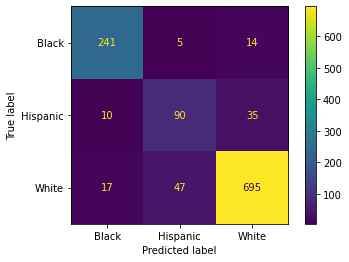

In [107]:
y_pred = svm_model_grid.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
plot_confusion_matrix(svm_model_grid,X_test,y_test);

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

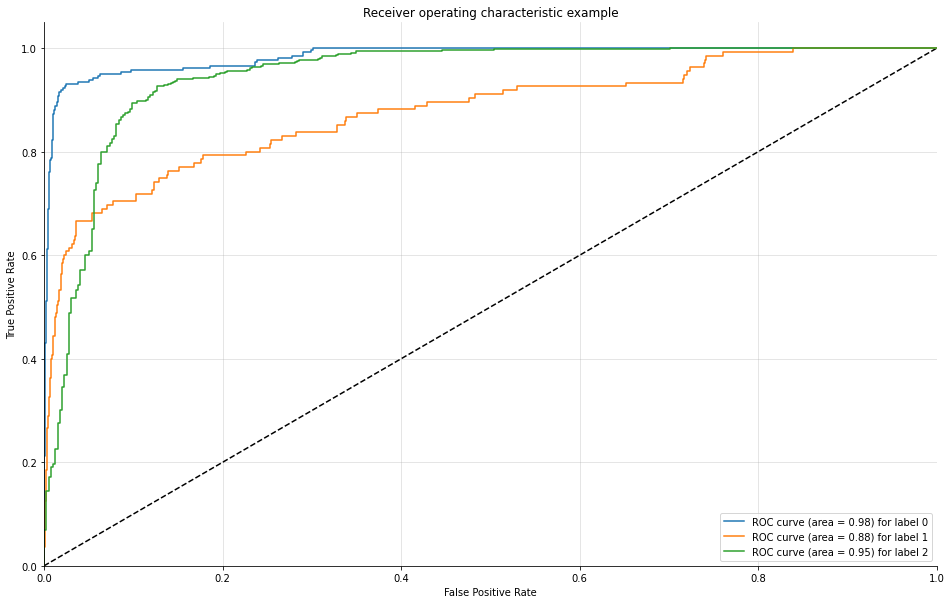

In [108]:
plot_multiclass_roc(svm_model_grid, X_test, y_test, n_classes=3, figsize=(16, 10))

## Xgboost Over/ Under Sampling

In [109]:
param_grid = {"n_estimators":[100, 300],
              'max_depth':[6,8],
              "learning_rate": [0.1, 0.3],
              "subsample":[0.5],
              "colsample_bytree":[0.5, 1]}

In [110]:
xgb_model = XGBClassifier()
xgb_grid_model = GridSearchCV(xgb_model, param_grid, scoring=f1_Hispanic, n_jobs = -1,refit=True, verbose = 2).fit(X_resampled, y_resampled)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[21:44:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [111]:
xgb_grid_model.best_params_

{'colsample_bytree': 1,
 'learning_rate': 0.1,
 'max_depth': 8,
 'n_estimators': 300,
 'subsample': 0.5}

[[226   2  32]
 [  9  68  58]
 [ 12  18 729]]
              precision    recall  f1-score   support

       Black       0.91      0.87      0.89       260
    Hispanic       0.77      0.50      0.61       135
       White       0.89      0.96      0.92       759

    accuracy                           0.89      1154
   macro avg       0.86      0.78      0.81      1154
weighted avg       0.88      0.89      0.88      1154



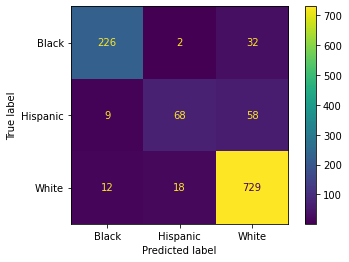

In [112]:
y_pred = xgb_grid_model.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
plot_confusion_matrix(xgb_grid_model,X_test,y_test);

In [113]:
from sklearn.metrics import matthews_corrcoef

matthews_corrcoef(y_test, y_pred)

0.7666116287172225

In [114]:
from sklearn.metrics import cohen_kappa_score

cohen_kappa_score(y_test, y_pred)

0.7615533245530327

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

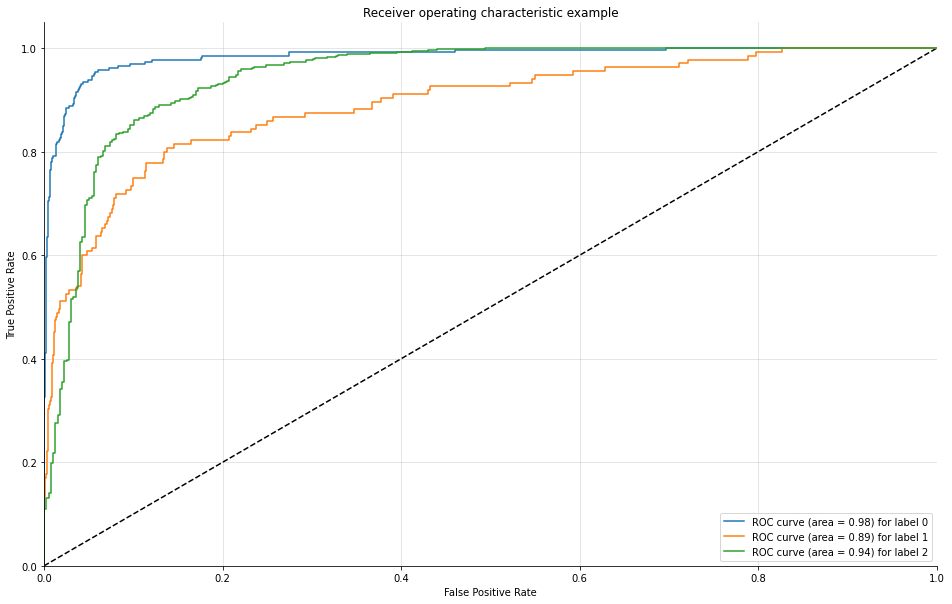

In [115]:
plot_multiclass_roc_for_tree(xgb_grid_model, X_test, y_test, n_classes=3, figsize=(16, 10))

---
---

---
---